<a href="https://colab.research.google.com/github/wildanputra/deeplearningtutorial/blob/master/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source : https://medium.com/@saidakbarp/real-time-face-recognition-tflite-3fb818ac039a

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#Visiulazation
import matplotlib.pyplot as plt
#image processing
import cv2
#extracting zippped file
import tarfile

## Mounting drive and dataset from gdrive

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
FACE = '/content/drive/My Drive/dataset/face/'
MODEL = '/content/drive/My Drive/model/'
#systems
import os
print(os.listdir(FACE))

FileNotFoundError: ignored

In [0]:
#example
imgg= FACE + "/randy/Randy.JPG"
randy=cv2.imread(imgg)

In [0]:
def show_image(image):
    plt.figure(figsize=(8,5))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [120]:
show_image(randy)

error: ignored

<Figure size 576x360 with 0 Axes>

## OPENCV DNN

In [0]:
# using openCV DNN
# load the model
#modelFile = MODEL + "opencv_face_detector_uint8.pb" 
#configFile = MODEL + "opencv_face_detector.pbtxt"
#net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

modelFile = MODEL + "opencvdnn/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = MODEL + "opencvdnn/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

In [0]:
#function to extract box dimensions
def face_dnn(img, coord=False):
    blob = cv2.dnn.blobFromImage(img, 1, (224,224), [104, 117, 123], False, False) #
    # params: source, scale=1, size=300,300, mean RGB values (r,g,b), rgb swapping=false, crop = false
    conf_threshold=0.8 # confidence at least 60%
    frameWidth=img.shape[1] # get image width
    frameHeight=img.shape[0] # get image height
    max_confidence=0
    net.setInput(blob)
    detections = net.forward()
    detection_index=0
    bboxes = []
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            
            if max_confidence < confidence: # only show maximum confidence face
                max_confidence = confidence
                detection_index = i
    i=detection_index        
    x1 = int(detections[0, 0, i, 3] * frameWidth)
    y1 = int(detections[0, 0, i, 4] * frameHeight)
    x2 = int(detections[0, 0, i, 5] * frameWidth)
    y2 = int(detections[0, 0, i, 6] * frameHeight)
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if coord==True:
        return x1, y1, x2, y2
    return cv_rgb

In [0]:
#gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# multiple faces needs increasing the size of image as well as multiple detections
def nfaces_dnn(img):
    blob = cv2.dnn.blobFromImage(img, 1.2, (1200,1200), [104, 117, 123], False, False) #
    # params: source, scale=1, size=300,300, mean RGB values (r,g,b), rgb swapping=false, crop = false
    conf_threshold=0.6 # confidence at least 60%
    frameWidth=img.shape[1] # get image width
    frameHeight=img.shape[0] # get image height
    net.setInput(blob)
    detections = net.forward()
  
    bboxes = []
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
                  
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

In [102]:
a=face_dnn(randy)
plt.figure(figsize=(15,18))
plt.imshow(a)
plt.show() 

error: ignored

## Creating training and test sets

In [0]:
pathd = '/content/drive/My Drive/dataset/face/'
yoga = 'yoga'
randy = 'randy'

In [0]:
dirs=os.listdir(pathd)
dirs.sort()

yoga
171 150 353 361


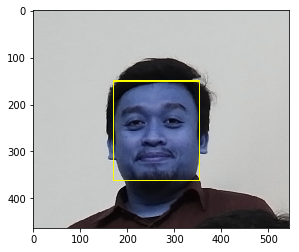

yoga
204 556 386 780


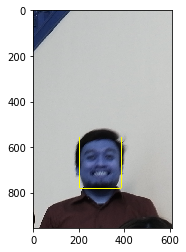

yoga
2043 764 2920 1880


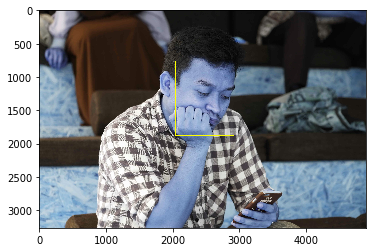

yoga
176 663 403 1048


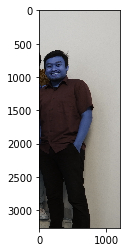

yoga
238 219 418 439


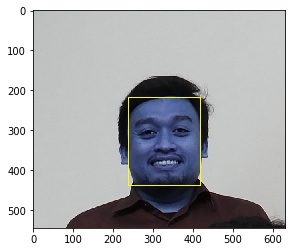

In [90]:
#example of box coordinates

for img in os.listdir(pathd+yoga)[:5]:
    #print(pathd+dirs[0]+'/'+img)
    print(yoga)
    img=cv2.imread(pathd+yoga+'/'+img)
    x1, y1, x2, y2=face_dnn(img, True)
    #print coordinates of the detected face
    print(x1, y1, x2, y2)
    plt.imshow(img)
    plt.show()

In [0]:
#remove unused folders
import shutil

In [123]:
# # creating test and train set
from numpy import random
datadir= '/content/drive/My Drive/dataset/'
train=datadir+'train/'
test=datadir+'test/'

if not os.path.exists(train):
    os.mkdir(train)
if not os.path.exists(test):
    os.mkdir(test)
    
for dirs in os.listdir(pathd):
    filenames = os.listdir(pathd+dirs)
    filenames.sort()  # make sure that the filenames have a fixed order before shuffling
    random.seed(402)
    random.shuffle(filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)
    split = int(0.9 * len(filenames))
    train_filenames = filenames[:split] # splitting filenames into two parts
    test_filenames = filenames[split:]
    for img in train_filenames:
        full_file_name = os.path.join(pathd+dirs, img)
        cur_dir=os.path.join(train+dirs)
        #print(cur_dir)
        if not os.path.exists(cur_dir): # create this current person's folder for training
            os.mkdir(cur_dir)
        shutil.copy(full_file_name, cur_dir)
    for img in test_filenames:
        full_file_name = os.path.join(pathd+dirs, img)
        cur_dir=os.path.join(test+dirs)
        if not os.path.exists(cur_dir): # create this current person's folder for testing
            os.mkdir(cur_dir)
        shutil.copy(full_file_name, cur_dir)
        #a=full_file_name+' '+test+dirs
shutil.rmtree('/content/drive/My Drive/dataset/face/')

FileNotFoundError: ignored

In [93]:
# total number of images left
total = sum([len(files) for r, d, files in os.walk(datadir)])
print(total)

77


In [0]:
# labels dir
labeldir="Labels/" 
wdir = '/content/drive/My Drive/dataset/'
lab=wdir+labeldir
if not os.path.exists(lab):
    os.mkdir(lab)

In [0]:
# function for creating box labels as txt file
def label_txt(pathdr, lab_dir):
    for fol in os.listdir(pathdr):
        print(pathdr)
        tfile = open(lab_dir+fol+".txt","w+")
        for img in os.listdir(pathdr+fol):
            pathimg=os.path.join(pathdr+fol, img)
            #print(pathimg)
            pic=cv2.imread(pathimg)
            x1, y1, x2, y2=face_dnn(pic, True) # face detection and then saving into txt file       
            tfile.write(img+' '+str(x1)+' '+str(x2)+' '+str(y1)+' '+str(y2)+'\n')          
        tfile.close()
    print('Saved')

# coba import lagi datasetnya, cek virus .ds_store

In [122]:
lab_dir=lab+'train/'
if not os.path.exists(lab):
    os.mkdir(lab_dir)
label_txt(train, lab_dir)

lab_dir=lab+'test/'
if not os.path.exists(lab):
    os.mkdir(lab_dir)
label_txt(test, lab_dir)

error: ignored

## Creating tfrecords with annotated images

In [0]:
def read_txt(person, photo):  
    txtfile = labels+person+".txt"
    txtfile_contents = open(txtfile, "r")
    txtlines = txtfile_contents.readlines()
    txtfile_contents.close()
    for line in txtlines:
        if photo in line:
            txtlines=line
    return txtlines

In [0]:
!pip install object_detection >obj_dtc.txt # installing object detection

In [0]:
from PIL import Image
from object_detection.utils import dataset_util

# flags = tf.app.flags
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# FLAGS = flags.FLAGS
# modified from source: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md
def create_tf_example(photo, person, iclass, foldr):
    # one image at a time
    img_f=os.path.join(foldr+person,photo+".jpg")
    pic = Image.open(img_f)
    height = pic.height # Image height
    width = pic.width # Image width
    filename = str.encode(photo) # Filename of the image. Empty if image is not from file
    #encoded_image_data = None # Encoded image bytes
    image_data = tf.gfile.GFile(img_f,'rb').read()
    
    image_format = b'jpeg' #None #  or b'png'
    #declare coordinates
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    txtlines = read_txt(person, photo)

    labels = txtlines.split()

    xmins.append(float(labels[1])/width)
    xmaxs.append(float(labels[2])/width)
    ymins.append(float(labels[3])/height)
    ymaxs.append(float(labels[4])/height)

    classes_text.append(str.encode(person))
    classes.append(iclass) #### iterator is needed
    #print(xmins, xmaxs, ymins, ymaxs, classes_text, photo, img_f) # for test purposes
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [0]:
import tensorflow as tf
#saving tfrecords
def save_tf(folder):
    tf_file=folder.split('/')[-2] +'.tfrecord'
    writer = tf.python_io.TFRecordWriter('../working/'+tf_file)
    
    labelmap = '../working/'+'object_label.pbtxt' # for model training
    txtf = open(labelmap, "w")
    
    labels = '../working/'+'labels.txt' # for android deployment
    txtl = open(labels, "w")
    
    for ind, person in enumerate(os.listdir(folder)):
        iclass=ind+1
        txtf.write("item\n{\n  id: %s\n  name: '%s'\n}\n"%(iclass,person))
        txtl.write("%s\n"%person)
        #print(iclass, person)
        for photo in os.listdir(folder+person):
            tf_example = create_tf_example(photo.split('.')[0], person, iclass, folder) #004.jpg, arnold, 1
            #print('Folder:', pathd+fol, iclass)
            writer.write(tf_example.SerializeToString())
    txtf.close()
    writer.close()